In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# Baseline: https://github.com/GoogleCloudPlatform/generative-ai/blob/main/embeddings/intro-textemb-vectorsearch.ipynb

# Getting Started with Text Embeddings + Vertex AI Vector Search

#### Install Python SDK

In [ ]:
%pip install --upgrade --user google-cloud-aiplatform google-cloud-storage 'google-cloud-bigquery[pandas]'

## Restart current runtime

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Environment variables

In [1]:
###### get project ID
PROJECT_ID = ! gcloud config get project
PROJECT_ID = PROJECT_ID[0]
LOCATION = "us-central1"
if PROJECT_ID == "(unset)":
    print(f"Please set the project ID manually below")

In [2]:
###### define project information
if PROJECT_ID == "(unset)":
    PROJECT_ID = "jc-gcp-project"  # @param {type:"string"}

# generate an unique id for this session
from datetime import datetime

UID = datetime.now().strftime("%m%d%H%M")

## Enable APIs

In [ ]:
! gcloud services enable compute.googleapis.com aiplatform.googleapis.com storage.googleapis.com bigquery.googleapis.com --project {PROJECT_ID}

Operation "operations/acat.p2-78565683329-0408be7c-09fd-455d-9128-7938b06891ee" finished successfully.


## Data Preparation

In [3]:
%%bigquery movie_post
SELECT * FROM `jc-gcp-project.sec_test.movie_post`;

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
movie_post.head()

,uri,generation,content_type,size,md5_hash,updated,metadata
0,gs://jc-gcp-project-01/movie_image/1.6_245943.jpg,1737037358604708,image/jpeg,14636,7d21baebd30c5c0bbe9a3f180e422898,2025-01-16 14:22:38.608000+00:00,[]
1,gs://jc-gcp-project-01/movie_image/1.6_56415.jpg,1737037359223573,image/jpeg,17426,64420725d11c9ad3e66b52057931ceb3,2025-01-16 14:22:39.226000+00:00,[]
2,gs://jc-gcp-project-01/movie_image/1.9_270846.jpg,1737037360302912,image/jpeg,19112,8f85cbce1387ca57236fc2a820eead97,2025-01-16 14:22:40.307000+00:00,[]
3,gs://jc-gcp-project-01/movie_image/1.9_60666.jpg,1737037358955801,image/jpeg,18049,5a799415894ba92e674d9647b8aff668,2025-01-16 14:22:38.958000+00:00,[]
4,gs://jc-gcp-project-01/movie_image/1.9_96870.jpg,1737037360171161,image/jpeg,14926,dc34b4a1ef97efe5b474837334ef87c5,2025-01-16 14:22:40.174000+00:00,[]


In [5]:
import io
import matplotlib.pyplot as plt
import tensorflow as tf

def showImage(gcs_uri):
    from PIL import Image
    """
    GCS URI를 입력으로 받아 이미지를 표시하는 함수

    Args:
        gcs_uri: GCS에 저장된 이미지의 URI (예: 'gs://bucket-name/image.jpg')
    """

    f = tf.io.gfile.GFile(gcs_uri, 'rb')
    stream = io.BytesIO(f.read())
    img = Image.open(stream)

    plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

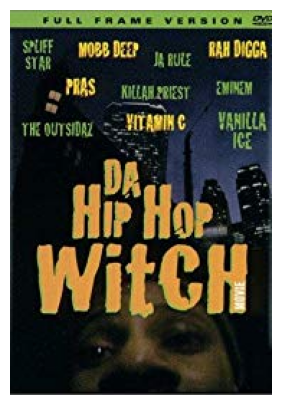

In [6]:
showImage(movie_post.iloc[0]['uri'])

## Call the API to generate embeddings

In [15]:
###### init the vertexai package
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

###### Load the text embeddings model
from vertexai.language_models import TextEmbeddingModel
from vertexai.vision_models import Image, MultiModalEmbeddingModel

###### Load Sth others
import pandas as pd
import numpy as np
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)

## API Usage Quota

In [ ]:
# TODO(developer): Try different dimenions: 128, 256, 512, 1408
embedding_dimension = 1408
model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

movie_post['embedding'] = None

for i in range(len(movie_post)):
    if i % 10 == 0:
        print(round((i/len(movie_post))*100, 0), '%, ', end = ' ')
        time.sleep(1)

    img_url = movie_post.iloc[i]['uri']
    # txt_url = df.iloc[i]['text']

    image = Image.load_from_file(
        img_url
    )

    embeddings = model.get_embeddings(
        image=image,
        # contextual_text=txt_url,
        dimension=embedding_dimension,
    )
    # df.embedding.iloc[i] = embeddings.image_embedding
    movie_post.embedding.iloc[i] = embeddings.image_embedding

0.0 %,  7.0 %,  14.0 %,  20.0 %,  27.0 %,  34.0 %,  41.0 %,  47.0 %,  54.0 %,  61.0 %,  68.0 %,  74.0 %,  81.0 %,  88.0 %,  95.0 %,  

In [11]:
movie_post.iloc[0]

,0
uri,gs://jc-gcp-project-01/movie_image/7.4_116209.jpg
generation,1737037408405041
content_type,image/jpeg
size,14336
md5_hash,e9d296d30b16a3049b6e61c038e51d08
updated,2025-01-16 14:23:28.408000+00:00
embedding,"[-0.0369878821, 0.0579172522, -0.00892025419, ..."


In [ ]:
movie_post_save = movie_post[['uri','generation','content_type','size','md5_hash','updated','embedding']]

In [ ]:
movie_post_save.head()

,uri,generation,content_type,size,md5_hash,updated,embedding
0,gs://jc-gcp-project-01/movie_image/1.6_245943.jpg,1737037358604708,image/jpeg,14636,7d21baebd30c5c0bbe9a3f180e422898,2025-01-16 14:22:38.608000+00:00,"[-0.0140182711, 0.040340811, 0.0254744068, -0...."
1,gs://jc-gcp-project-01/movie_image/1.6_56415.jpg,1737037359223573,image/jpeg,17426,64420725d11c9ad3e66b52057931ceb3,2025-01-16 14:22:39.226000+00:00,"[0.015315881, 0.0580138043, 0.0219896603, -0.0..."
2,gs://jc-gcp-project-01/movie_image/1.9_270846.jpg,1737037360302912,image/jpeg,19112,8f85cbce1387ca57236fc2a820eead97,2025-01-16 14:22:40.307000+00:00,"[-0.0381799378, 0.0259109419, 0.034066353, -0...."
3,gs://jc-gcp-project-01/movie_image/1.9_60666.jpg,1737037358955801,image/jpeg,18049,5a799415894ba92e674d9647b8aff668,2025-01-16 14:22:38.958000+00:00,"[-0.0314356908, 0.0449913889, -0.00880988408, ..."
4,gs://jc-gcp-project-01/movie_image/1.9_96870.jpg,1737037360171161,image/jpeg,14926,dc34b4a1ef97efe5b474837334ef87c5,2025-01-16 14:22:40.174000+00:00,"[-0.0317693278, 0.0386252329, 0.00868705753, -..."


In [ ]:
# BigQuery 테이블 정보 설정
project_id = 'jc-gcp-project'  # 프로젝트 ID
dataset_id = 'sec_test'  # 데이터셋 ID
table_id = 'movie_post_embeddings'  # 테이블 ID

# DataFrame을 BigQuery 테이블로 저장
movie_post_save.to_gbq(f'{dataset_id}.{table_id}', project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 10407.70it/s]


In [18]:
#### Embedding Cell 실행시 생략 (저장된 내용 가져오기)
%%bigquery movie_post_save
SELECT * FROM `jc-gcp-project.sec_test.movie_post_embeddings`;

Query is running:   0%|          |

Downloading:   0%|          |

In [19]:
movie_post_save.iloc[0]

,0
uri,gs://jc-gcp-project-01/movie_image/7.4_116209.jpg
generation,1737037408405041
content_type,image/jpeg
size,14336
md5_hash,e9d296d30b16a3049b6e61c038e51d08
updated,2025-01-16 14:23:28.408000+00:00
embedding,"[-0.0369878821, 0.0579172522, -0.00892025419, ..."


## Get Randome one & Check similarity w/ Dot

In [13]:
# TODO(developer): Try different dimenions: 128, 256, 512, 1408
embedding_dimension = 1408
model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

Key question: man and woman dancing under light



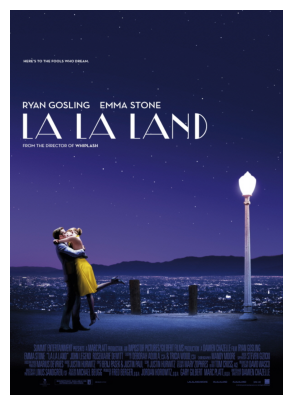

0.0776 gs://jc-gcp-project-01/movie_image/lala_post.jpg
0.0703 gs://jc-gcp-project-01/movie_image/3.2_99969.jpg
0.0406 gs://jc-gcp-project-01/movie_image/2.8_266747.jpg
0.0393 gs://jc-gcp-project-01/movie_image/3.5_84316.jpg
0.0385 gs://jc-gcp-project-01/movie_image/2.4_299930.jpg
0.0342 gs://jc-gcp-project-01/movie_image/2.8_54240.jpg
0.0341 gs://jc-gcp-project-01/movie_image/8.4_59026.jpg
0.0338 gs://jc-gcp-project-01/movie_image/3.6_291502.jpg
0.0333 gs://jc-gcp-project-01/movie_image/3.6_160498.jpg
0.0325 gs://jc-gcp-project-01/movie_image/2.2_57181.jpg


In [20]:
want_to_find = "man and woman dancing under light"

# emb_val = model.get_embeddings(
#     [want_to_find],
# )

emb_val = model.get_embeddings(
    # image=image,
    contextual_text=want_to_find,
    dimension=embedding_dimension,
)

# calc dot product between the key and other questions
embs = np.array(movie_post_save.embedding.to_list())
similarities = np.dot(emb_val.text_embedding, embs.T)
# print the question
print(f"Key question: {want_to_find}\n")

# sort and print the questions by similarities
sorted_questions = sorted(
    zip(movie_post_save.uri, similarities), key=lambda x: x[1], reverse=True
)[:10]
# Show Image
showImage(sorted_questions[0][0])
for i, (question, similarity) in enumerate(sorted_questions):
    print(f"{similarity:.4f} {question}")